In [1]:
import json
from collections import Counter, defaultdict
import spacy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import webvtt
from pathlib import Path

# Setup

In [2]:
sns.set_style("whitegrid")

In [3]:
nlp = spacy.load("es_core_news_sm")
ROOT_DIR = Path(os.getcwd())
CORPUS_DIR = ROOT_DIR / "test-corpus"
movie_info = {}
retrieval_performance = {}
num_retrieved = [10, 20, 50, 100]

In [4]:
def tokenize(caption: str) -> list[str]:
    caption = nlp(caption)
    return [token.text for token in caption if not token.is_punct]

In [5]:
def clean_summary(summary: str) -> str:
    summary = summary.replace('\n', ' '). replace('(', '').replace(')', '')
    summary = summary.lower().strip()
    
    return summary

In [6]:
def clean_caption(caption: str) -> str:
    """Clean up peculiarilities in vtt info."""
    caption = caption.replace('\n', ' ').replace('-', '')
    caption = caption.lower().strip()
    return caption

In [7]:
def get_summary_tokens(model, summary: str) -> set[str]:
    summary = model(clean_summary(summary))
    
    return set([token.text for token in summary if not token.is_punct])

In [8]:
for subdir, dirs, files in os.walk(CORPUS_DIR):
    if files:
        movie_name = subdir[subdir.rfind('/')+1:]
        movie_info[movie_name] = {}

        for file in files:
            file_path = os.path.join(subdir, file)
            if file.endswith('es.json'):
                with open(file_path, 'r') as f:
                     movie_info[movie_name]['json'] = json.load(f)
            if file.endswith('.txt'):
                with open(file_path, 'r') as f:
                    summary = f.read()
                movie_info[movie_name]['summary'] = get_summary_tokens(nlp, summary)
            if file.endswith('es.vtt'):
                captions = [line.text for line in webvtt.read(file_path)]
                movie_info[movie_name]['vtt'] = list(map(clean_caption, captions))

In [9]:
def json_retrieve_top_x(word_info: dict[dict], key: str, x: int) -> set[str]:
    """Retrieve top x word from JSON based on the given key"""
    ranking = [(word, value[key]) for word, value in word_info.items()]
    ranking.sort(key = lambda x: x[1], reverse=True)
    return set([i[0] for i in ranking[:x]])

In [10]:
def eval_retrieval(retrieved: set[str], actual: set[str]) -> float:
    """Percentage of retrieved tokens that are also summary tokens."""
    return len(retrieved & actual) / len(retrieved)

for movie in movie_info:
    retrieval_performance[movie] = defaultdict(dict)

# Evaluate Tfidf

In [12]:
retrieval_key = ['tf', 'df', 'tfidf']

for movie, info in movie_info.items():
    for key in retrieval_key:
        key_performance = []
        for num in num_retrieved:
            top_words = json_retrieve_top_x(info['json'], key, num)
            performance = eval_retrieval(top_words, info['summary'])
            key_performance.append(performance)
        retrieval_performance[movie][key] = key_performance

In [13]:
tf_performance = np.array([val['tf'] for val in retrieval_performance.values()]).mean(axis=0)
df_performance = np.array([val['df'] for val in retrieval_performance.values()]).mean(axis=0)
tfidf_performance = np.array([val['tfidf'] for val in retrieval_performance.values()]).mean(axis=0)

Text(0.5, 1.0, 'TfIdf Retrieval Performance at Different Retrieval Amounts')

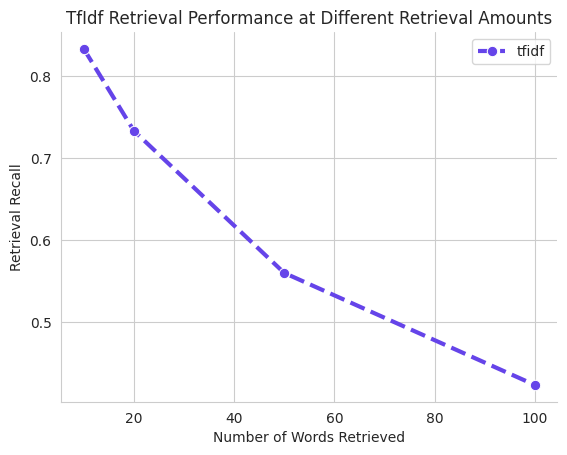

In [62]:
# fig = plt.subplots()
# sns.lineplot(
#     x=num_retrieved,
#     y=tfidf_performance,
#     label='tfidf',
#     marker='o',
#     linestyle='--',
#     c="#6544e9",
#     lw=3,
#     ms=7.5
# )
# sns.despine()
# plt.xlabel("Number of Words Retrieved")
# plt.ylabel("Retrieval Recall")
# plt.title("TfIdf Retrieval Performance at Different Retrieval Amounts")
# # plt.savefig("tfidf_performance.png", dpi=200)

# Evaluate LSA

In [15]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [16]:
vectorizer = TfidfVectorizer(tokenizer=tokenize)

In [17]:
for info in movie_info.values():
    info["tfidf_matrix"] = vectorizer.fit_transform(info['vtt'])

/home/robery/.local/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [18]:
def calc_explained_variance(feature_matrix, num_topics: list[int]):
    performance = []
    for num_topic in num_topics: 
        svd = TruncatedSVD(n_components=num_topic, random_state=42)
        svd.fit(feature_matrix)
        performance.append(svd.explained_variance_ratio_.sum())
    
    return performance

In [19]:
num_topics = [i*5 for i in range(1, 11)]

for movie, info in movie_info.items():
    explained_variance = calc_explained_variance(info['tfidf_matrix'], num_topics)
    retrieval_performance[movie]["lsa_explained_variance"] = explained_variance

In [20]:
lsa_explained_variance = np.array([val["lsa_explained_variance"] for val in retrieval_performance.values()]).mean(axis=0)

In [21]:
# fig = plt.subplots()
# sns.lineplot(
#     x=np.array(num_topics),
#     y=lsa_explained_variance,
#     label='LSA',
#     marker='o',
#     linestyle='--',
#     c="#6544e9",
#     lw=3,
#     ms=7.5
# )
# sns.despine()
# plt.xlabel("Number of Topics")
# plt.ylabel("Explained Variance Ratio")
# plt.title("Latent Semantic Analysis Performance")
# plt.savefig("lsa_explained_variance.png", dpi=200)

In [22]:
from math import ceil

def lsa_retrieve_top_x(vtt, x: int, num_topics: int = 50) -> set[str]:
    feature_matrix = vectorizer.fit_transform(vtt)
    svd = TruncatedSVD(n_components=num_topics, random_state=42)
    svd.fit(feature_matrix)

    terms = vectorizer.get_feature_names_out()

    top_terms = set()

    for i, comp in enumerate(svd.components_):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key=lambda x:x[1], reverse=True)[:ceil(x / num_topics)]
        top_terms.update(i[0] for i in sorted_terms)

    return top_terms

In [25]:
for movie, info in movie_info.items():
    lsa_performance = []
    for num in num_retrieved:
        top_words = lsa_retrieve_top_x(info['vtt'], num)
        performance = eval_retrieval(top_words, info['summary'])
        lsa_performance.append(performance)
    retrieval_performance[movie]["lsa_performance"] = lsa_performance

/home/robery/.local/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [28]:
lsa_performance= np.array([val["lsa_performance"] for val in retrieval_performance.values()]).mean(axis=0)

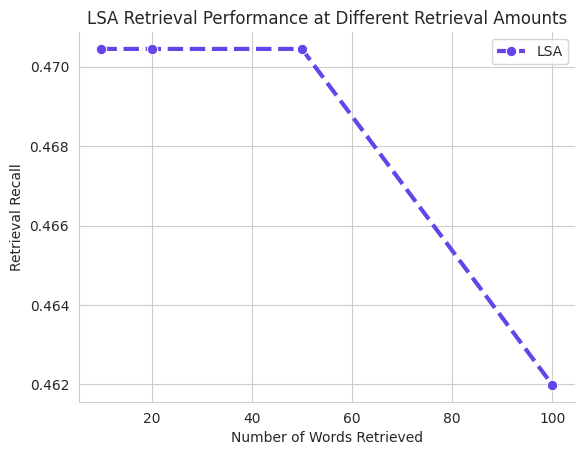

In [32]:
# fig = plt.subplots()
# sns.lineplot(
#     x=num_retrieved,
#     y=lsa_performance,
#     label='LSA',
#     marker='o',
#     linestyle='--',
#     c="#6544e9",
#     lw=3,
#     ms=7.5
# )
# sns.despine()
# plt.xlabel("Number of Words Retrieved")
# plt.ylabel("Retrieval Recall")
# plt.title("LSA Retrieval Performance at Different Retrieval Amounts")
# plt.savefig("lsa_performance.png", dpi=200)

# Evaluate LDA

In [38]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel

In [34]:
movie_info["Whiplash"].keys()

dict_keys(['summary', 'json', 'vtt', 'tfidf_matrix'])

In [37]:
for movie, info in movie_info.items():
    info["tokens"] = list(map(tokenize, info["vtt"]))

In [50]:
def lda_retrieve_top_x(captions: list[list[str]], x: int, num_topics: int = 10) -> set[str]:
    """Captions should already be tokenized."""
    dictionary = corpora.Dictionary(captions)
    doc_term_matrix = [dictionary.doc2bow(caption) for caption in captions]

    lda_model = LdaModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary, random_state=42)
    top_words = lda_model.show_topics(num_topics=num_topics, num_words=ceil(x / num_topics), formatted=False)

    top_x = set()
    for _, words in top_words:
        top_x.update(i[0] for i in words)

    return top_x

In [52]:
for movie, info in movie_info.items():
    lda_performance = []
    for num in num_retrieved:
        top_words = lda_retrieve_top_x(info['tokens'], num)
        performance = eval_retrieval(top_words, info['summary'])
        lda_performance.append(performance)
    retrieval_performance[movie]["lda_performance"] = lda_performance

In [54]:
lda_performance= np.array([val["lda_performance"] for val in retrieval_performance.values()]).mean(axis=0)

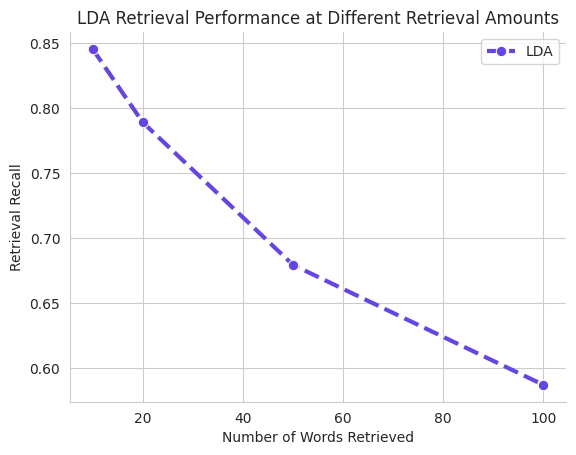

In [57]:
# fig = plt.subplots()
# sns.lineplot(
#     x=num_retrieved,
#     y=lda_performance,
#     label='LDA',
#     marker='o',
#     linestyle='--',
#     c="#6544e9",
#     lw=3,
#     ms=7.5
# )
# sns.despine()
# plt.xlabel("Number of Words Retrieved")
# plt.ylabel("Retrieval Recall")
# plt.title("LDA Retrieval Performance at Different Retrieval Amounts")
# plt.savefig("lda_performance.png", dpi=200)

# Visualization

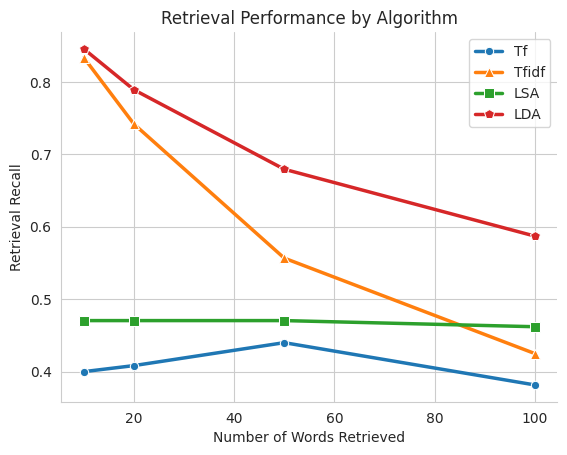

In [70]:
plt.subplots()
sns.lineplot(
    x=num_retrieved,
    y=tfidf_performance,
    label="Tf",
    marker='o',
    lw=2.5
)
sns.lineplot(
    x=num_retrieved,
    y=tf_performance,
    label="Tfidf",
    marker='^',
    ms=7.5,
    lw=2.5
)
sns.lineplot(
    x=num_retrieved,
    y=lsa_performance,
    label="LSA",
    marker='s',
    ms=7.5,
    lw=2.5
)
sns.lineplot(
    x=num_retrieved,
    y=lda_performance,
    label="LDA",
    marker='p',
    ms=7.5,
    lw=2.5
)
sns.despine()
plt.xlabel("Number of Words Retrieved")
plt.ylabel("Retrieval Recall")
plt.title("Retrieval Performance by Algorithm")
plt.savefig("all_performance.png", dpi=200)